# Timeseries Circuits
*TS utilities in Qiskit*

By: Jacob Cybulski<br>
Date: August 2023 - March 2024<br>
Aims: The goal of this notebook is to test some of the QuTSAE circuits and their elements.

## Initial settings

In [1]:
%%html
<style>
table {float:left}
</style>

In [2]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path

['/home/jacob/Dropbox/Dev/Python/quantum_projects/ts/ts_denoise/utils',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python310.zip',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.10',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.10/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/qiskit-gpu/lib/python3.10/site-packages',
 '.',
 '..']

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pylab
import math
from IPython.display import clear_output

from matplotlib import set_loglevel
set_loglevel("error")

%matplotlib inline

## Building and training a Quantum Autoencoder

In [4]:
### Libraries used in QAE development

from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, TwoLocal, ZFeatureMap, ZZFeatureMap
from qiskit.circuit import Parameter

from utils.Circuits import *

### Sequence encoder
The sequence is encoded as a series of angle rotations


Input parameters for the sequence:  [Parameter(In(0)), Parameter(In(1)), Parameter(In(2)), Parameter(In(3)), Parameter(In(4)), Parameter(In(5))]




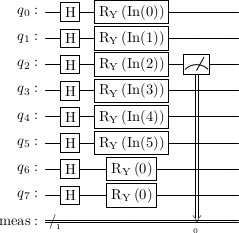

In [5]:
### Test a sample sequence encoder
sample_seq, inp_params = sequence_encoder(8, 6, classreg=True, meas_q=2, label='In')
print('\nInput parameters for the sequence: ', inp_params)
print('\n')
display(sample_seq.draw(output='latex', style="iqp", fold=False, scale=0.7))



Input parameters for the sequence:  [ParameterVectorElement(In[0]), ParameterVectorElement(In[1]), ParameterVectorElement(In[2])]




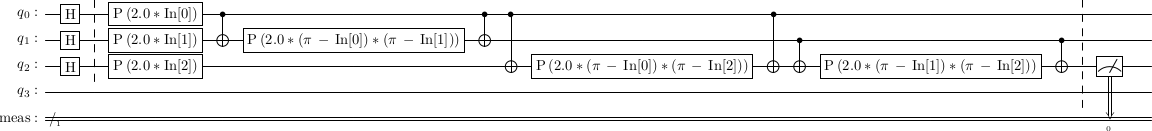

In [6]:
### Test a sample ZZ sequence encoder
sample_seq, inp_params = sequence_zz_encoder(4, 3, classreg=True, reps=1, meas_q=2, label='In')
print('\nInput parameters for the sequence: ', inp_params)
print('\n')
display(sample_seq.decompose().decompose().draw(output='latex', style="iqp", fold=False, scale=0.7))

**Figure: Example of encoding for a sample sequence window**

### Creation of an ansatze

The selectede ansatze are the Qiskit RealAmplitude and TwoLocal ansatze. 


Number of ansatz parameters: 24



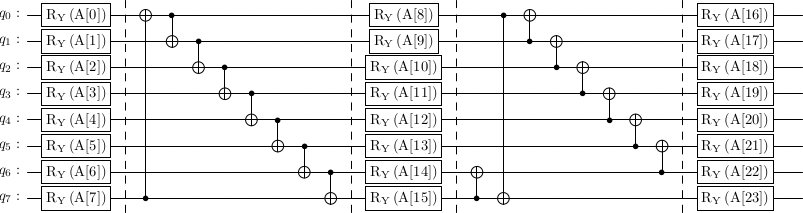

In [7]:
### Test the selected ansatz
sample_ansatz = ansatz(8, reps=2, ent='sca', insert_barriers=True) # linear, reverse_linear, full, circular, sca
print(f'\nNumber of ansatz parameters: {len(sample_ansatz.parameters)}\n')
display(sample_ansatz.decompose().draw("latex", style="iqp", scale=0.7, fold=False))


Number of ansatz parameters: 48



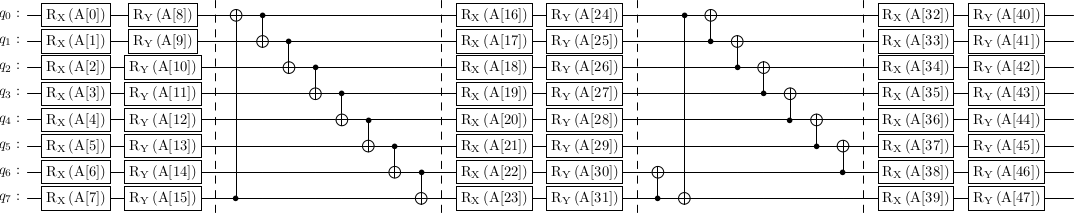

In [8]:
### Test the selected ansatz
sample_ansatz = ansatz_xy(8, reps=2, ent='sca', insert_barriers=True) # linear, reverse_linear, full, circular, sca
print(f'\nNumber of ansatz parameters: {len(sample_ansatz.parameters)}\n')
display(sample_ansatz.decompose().draw("latex", style="iqp", scale=0.7, fold=False))

**Figure: Sample QAE ansatz**

### Swap Test
For two qubts, it returns a squared inner product between their states. In this implementation, it estimates the overlap between the states of all participating qubits. 
The repeated measurement of 1 indicates that the quantum states are identical. For two qubits, if the measurement returns 0.5 then the two states are orthogonal.
However, orthogonality of the remaining states is no longer possible, so the measurements will be further away from 1, possibly confusing the outcome.


Example swap test circuit: 7



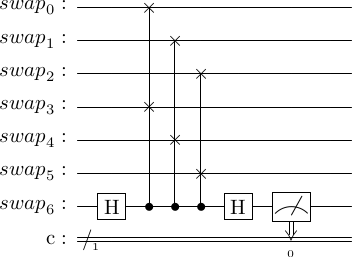

In [9]:
### Test a swap test circuit
sample_swap_qc = swap_test(3)
print(f'\nExample swap test circuit: {len(sample_swap_qc.qubits)}\n')
display(sample_swap_qc.draw("latex", style="iqp", scale=1))

### Half-QAE Encoder/Decoder$^\dagger$:<br/>Pure Input + Encoder/Decoder$^\dagger$ + Swap Test
It creates a encoder/decoder$^\dagger$ with input to be trained with the use of swap space on trash qubits.<br/>
To create a decoder$^\dagger$ pass inverse=True, later in testing to be reversed again.



Example autoencoder circuit (with 5 latent and 3 trash qubits):

Encoder parameters:
ParameterView([ParameterVectorElement(X[0]), ParameterVectorElement(X[1]), ParameterVectorElement(X[2]), ParameterVectorElement(X[3]), ParameterVectorElement(X[4]), ParameterVectorElement(X[5]), ParameterVectorElement(X[6]), ParameterVectorElement(X[7]), ParameterVectorElement(X[8]), ParameterVectorElement(X[9]), ParameterVectorElement(X[10]), ParameterVectorElement(X[11]), ParameterVectorElement(X[12]), ParameterVectorElement(X[13]), ParameterVectorElement(X[14]), ParameterVectorElement(X[15])])

In/Out  parameters:
ParameterView([Parameter(S(0)), Parameter(S(1)), Parameter(S(2)), Parameter(S(3)), Parameter(S(4)), Parameter(S(5)), Parameter(S(6)), Parameter(S(7))])






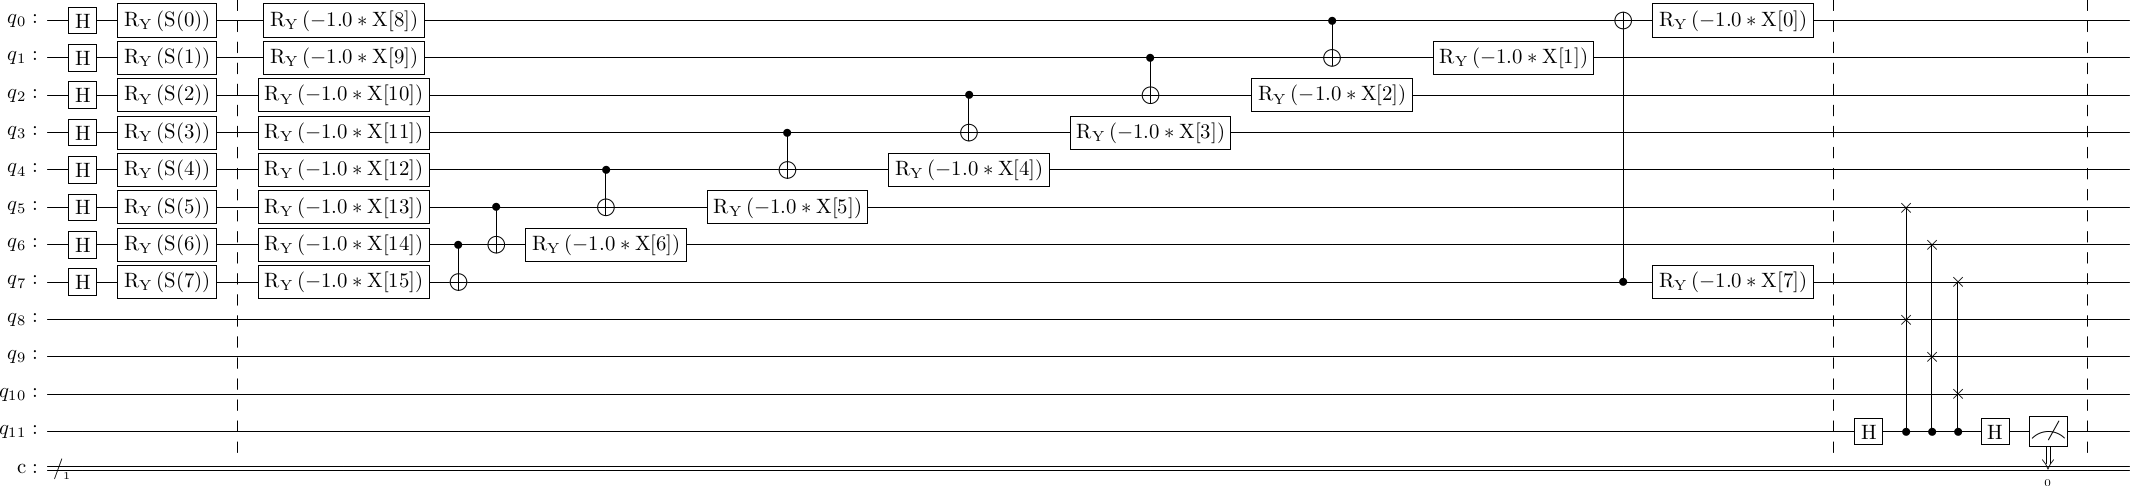

In [10]:
### Test an encoder circuit
sample_lat=5; sample_trash=3
sample_aec, sample_fm_parameters, sample_anz_parameters = \
    half_qae_encoder_with_swap_test(sample_lat, sample_trash, reps=1, ent='sca', seq_label='S', seq_name='Sequence', inverse=True)

print()
print(f'\nExample autoencoder circuit (with {sample_lat} latent and {sample_trash} trash qubits):')
print(f'\nEncoder parameters:\n{sample_anz_parameters}')
print(f'\nIn/Out  parameters:\n{sample_fm_parameters}\n\n')

print('\n')
display(sample_aec.decompose().draw("latex", style="iqp", scale=1)) #, cregbundle=False))
print('\n')

**Figure: Half-QAE structure for training using only Encoder and the Swap Test**<br/>
The swap test compares the states of qubits in the trash space with qubits initialised with $\lvert 0 \rangle$

### Full-QAE:<br/>Noisy Input + Encoder + Latent Space + Decoder$^\dagger$ + Pure Input + Swap Test
The encoder is to be trained with noisy input. Both the encoder and decoder need to be trained together. They converge onto the pure data encoded in separate qubits via a swap test.



Example autoencoder circuit (with 5 latent and 3 trash qubits):

Pure out-parameters:
ParameterView([Parameter(P(0)), Parameter(P(1)), Parameter(P(2)), Parameter(P(3)), Parameter(P(4)), Parameter(P(5)), Parameter(P(6)), Parameter(P(7))])

Noisy in-parameters:
ParameterView([Parameter(N(0)), Parameter(N(1)), Parameter(N(2)), Parameter(N(3)), Parameter(N(4)), Parameter(N(5)), Parameter(N(6)), Parameter(N(7))])

Encoder parameters:
ParameterView([ParameterVectorElement(X[0]), ParameterVectorElement(X[1]), ParameterVectorElement(X[2]), ParameterVectorElement(X[3]), ParameterVectorElement(X[4]), ParameterVectorElement(X[5]), ParameterVectorElement(X[6]), ParameterVectorElement(X[7]), ParameterVectorElement(X[8]), ParameterVectorElement(X[9]), ParameterVectorElement(X[10]), ParameterVectorElement(X[11]), ParameterVectorElement(X[12]), ParameterVectorElement(X[13]), ParameterVectorElement(X[14]), ParameterVectorElement(X[15])])

Decoder parameters:
ParameterView([ParameterVectorElement(Y[0]

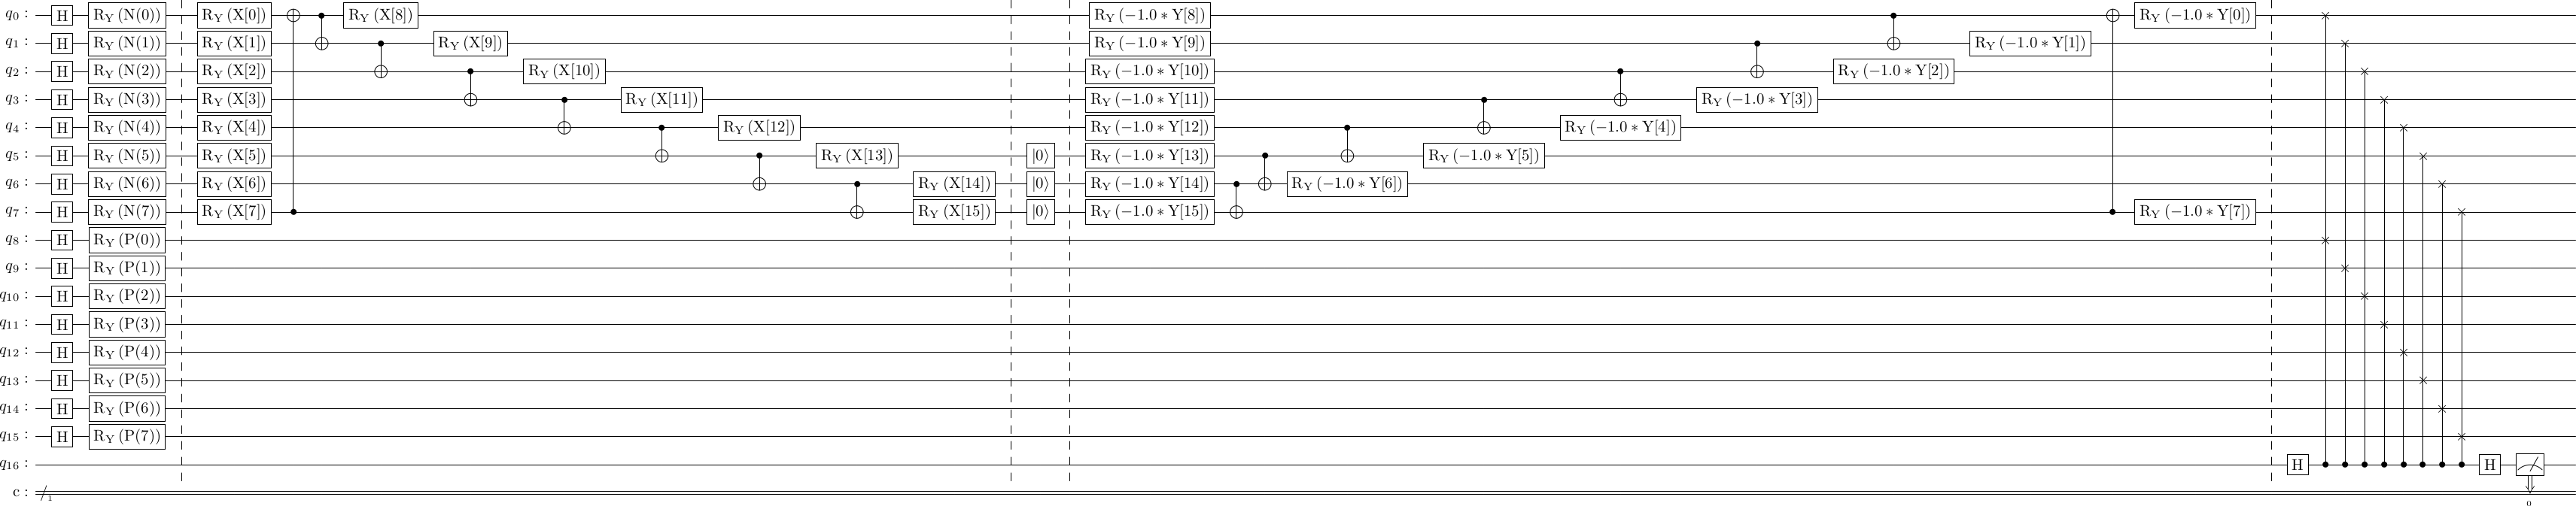

In [11]:
sample_lat=5; sample_trash=3

sample_qae, pure_out_params, decoder_params, noisy_in_params, encoder_params = \
    full_qae_encoder_with_swap(sample_lat, sample_trash, reps=1, ent='sca',
                  pure_seq_name='Pure Input', pure_seq_label='P', 
                  noisy_seq_name='Noisy Input', noisy_seq_label='N', 
                  enc_name='Encoder', enc_label='X',
                  dec_name='Decoder', dec_label='Y')

print()
print(f'\nExample autoencoder circuit (with {sample_lat} latent and {sample_trash} trash qubits):')
print(f'\nPure out-parameters:\n{pure_out_params}')
print(f'\nNoisy in-parameters:\n{noisy_in_params}')
print(f'\nEncoder parameters:\n{encoder_params}')
print(f'\nDecoder parameters:\n{decoder_params}\n\n')

print('\n')
display(sample_qae.decompose().draw("latex", style="iqp", scale=1)) #, cregbundle=False))
print('\n')

### Half-QAE Encoder with Sidekick Decoder$^\dagger$:<br/>Noisy Input + Encoder + Swap Test + Sidekick (Decoder$^\dagger$ + Pure Input)
It creates an encoder using the previously trained sidekick decoder$^\dagger$ by converging their common latent space.<br/>
The encoder is to be trained with noisy input and ensuring its latent space converges with that produced by the decoder$^\dagger$ from pure data.



Example autoencoder circuit (with 5 latent and 3 trash qubits):

Pure In params:
ParameterView([Parameter(I(0)), Parameter(I(1)), Parameter(I(2)), Parameter(I(3)), Parameter(I(4)), Parameter(I(5)), Parameter(I(6)), Parameter(I(7))])

Decoder params:
ParameterView([ParameterVectorElement(Y[0]), ParameterVectorElement(Y[1]), ParameterVectorElement(Y[2]), ParameterVectorElement(Y[3]), ParameterVectorElement(Y[4]), ParameterVectorElement(Y[5]), ParameterVectorElement(Y[6]), ParameterVectorElement(Y[7]), ParameterVectorElement(Y[8]), ParameterVectorElement(Y[9]), ParameterVectorElement(Y[10]), ParameterVectorElement(Y[11]), ParameterVectorElement(Y[12]), ParameterVectorElement(Y[13]), ParameterVectorElement(Y[14]), ParameterVectorElement(Y[15])])

Noisy In params:
ParameterView([Parameter(N(0)), Parameter(N(1)), Parameter(N(2)), Parameter(N(3)), Parameter(N(4)), Parameter(N(5)), Parameter(N(6)), Parameter(N(7))])

Encoder params:
ParameterView([ParameterVectorElement(X[0]), ParameterVecto

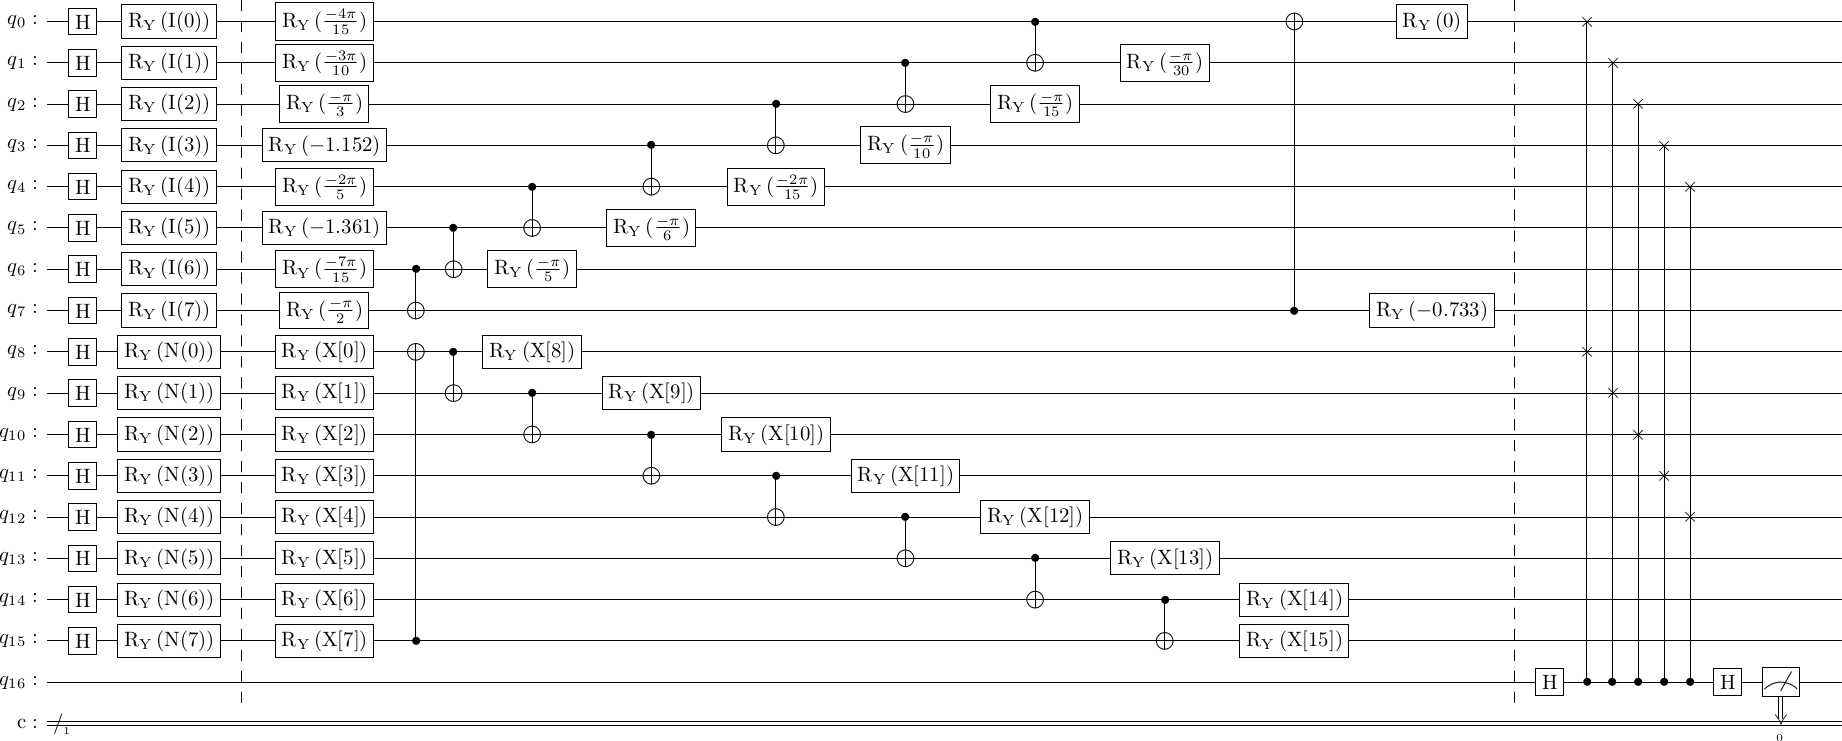

In [12]:
### Test an encoder circuit
sample_lat=5; sample_trash=3
sample_aec, sample_pure_in_params, sample_dec_params, sample_noisy_in_params, sample_enc_params = \
    half_qae_encoder_with_sidekick(sample_lat, sample_trash, reps=1, ent='sca', 
                  pure_seq_name='Pure In', pure_seq_label='I', noisy_seq_name='Noisy In', noisy_seq_label='N', 
                  enc_name='Enc', enc_label='X', dec_name='Dec', dec_label='Y')

### Print all parameters
print()
print(f'\nExample autoencoder circuit (with {sample_lat} latent and {sample_trash} trash qubits):')
print(f'\nPure In params:\n{sample_pure_in_params}')
print(f'\nDecoder params:\n{sample_dec_params}')
print(f'\nNoisy In params:\n{sample_noisy_in_params}')
print(f'\nEncoder params:\n{sample_enc_params}')

### Assign decoder parameters to their optimum (simulated)
dec_param_vals = np.linspace(0, 0.5*np.pi, num=len(sample_dec_params))
sample_aec.assign_parameters({k:v for (k,v) in zip(sample_dec_params,dec_param_vals) }, inplace=True)

### Display the circuit with assigned decoder parameters
print('\n')
display(sample_aec.decompose().draw("latex", style="iqp", scale=1))
# display(sample_aec.draw("latex", style="iqp", scale=1, cregbundle=False))
print('\n')

**Figure: Half-QAE with Sidekick structure for training the Encoder with the Swap Test and previously trained Sidekick Decoder$^\dagger$**<br/>
The swap test compares the states of qubits in the latent space of both the Encoder and Decoder$^\dagger$

***

### Full-QAE Stacked Encoder and (optionally) previously trained Decoder$^\dagger$:<br/>Noisy Input + Encoder + Latent Space + Decoder + Pure Input$^\dagger$
It creates a full QAE to train its encoder using the previously trained decoder$^\dagger$ by converging the output to $\vert 0 \rangle^n$.<br/>
The encoder is to be trained with noisy input trough the latent space, then the decoder (no $^\dagger$), pure data$^\dagger$, to result in $\vert 0 \rangle^n$.<br/>
For training, all qubits of this Full-QAE will be measured.



Example autoencoder circuit (with 5 latent and 3 trash qubits):

Pure In params:
ParameterView([Parameter(P(0)), Parameter(P(1)), Parameter(P(2)), Parameter(P(3)), Parameter(P(4)), Parameter(P(5)), Parameter(P(6)), Parameter(P(7))])

Decoder params:
ParameterView([ParameterVectorElement(Y[0]), ParameterVectorElement(Y[1]), ParameterVectorElement(Y[2]), ParameterVectorElement(Y[3]), ParameterVectorElement(Y[4]), ParameterVectorElement(Y[5]), ParameterVectorElement(Y[6]), ParameterVectorElement(Y[7]), ParameterVectorElement(Y[8]), ParameterVectorElement(Y[9]), ParameterVectorElement(Y[10]), ParameterVectorElement(Y[11]), ParameterVectorElement(Y[12]), ParameterVectorElement(Y[13]), ParameterVectorElement(Y[14]), ParameterVectorElement(Y[15])])

Noisy In params:
ParameterView([Parameter(N(0)), Parameter(N(1)), Parameter(N(2)), Parameter(N(3)), Parameter(N(4)), Parameter(N(5)), Parameter(N(6)), Parameter(N(7))])

Encoder params:
ParameterView([ParameterVectorElement(X[0]), ParameterVecto

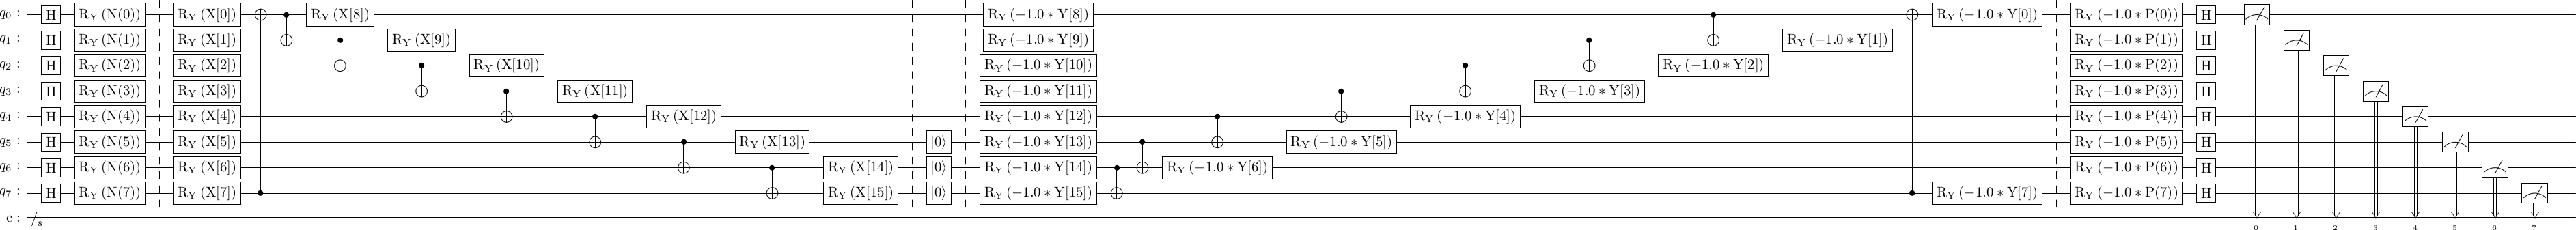

In [13]:
### Test an encoder circuit
sample_lat=5; sample_trash=3
sample_aec, sample_pure_in_params, sample_dec_params, sample_noisy_in_params, sample_enc_params = \
    full_qae_stacked(sample_lat, sample_trash, reps=1, ent='sca', 
                  pure_seq_name='Pure In', pure_seq_label='P', noisy_seq_name='Noisy In', noisy_seq_label='N', 
                  enc_name='Enc', enc_label='X', dec_name='Dec', dec_label='Y')

### Print all parameters
print()
print(f'\nExample autoencoder circuit (with {sample_lat} latent and {sample_trash} trash qubits):')
print(f'\nPure In params:\n{sample_pure_in_params}')
print(f'\nDecoder params:\n{sample_dec_params}')
print(f'\nNoisy In params:\n{sample_noisy_in_params}')
print(f'\nEncoder params:\n{sample_enc_params}')

### Assign decoder parameters to their optimum (simulated)
dec_param_vals = np.linspace(0, 0.5*np.pi, num=len(sample_dec_params))
# sample_aec.assign_parameters({k:v for (k,v) in zip(sample_dec_params,dec_param_vals) }, inplace=True)

### Display the circuit with assigned decoder parameters
print('\n')
display(sample_aec.decompose().draw("latex", style="iqp", scale=1))
print('\n')

**Figure: Full-QAE Stacked Encoder and previously trained (Sidekick) Decoder$^\dagger$**<br/>
All qubits are being measured to check for the output to be $\vert 0 \rangle^n$ and $cost = P(1-\lvert 0 \rangle)^n$.

### Half-QAE Encoder: Input + Encoder without a Swap Test
It assesses the state of all trash qubits to be $\lvert 0 \rangle$ by their direct measurement and estimating the probability $P(\lvert 0 \rangle)^n$ (where $n$ is the number of qubits in the trash space. This approach to measuring qubit similarity is not as nuanced as what's is provided by swap test, as we miss on the state proximity determined by their inner product. However, the measurement is fast(er) and does not need additional qubits. The circuit training needs the cost function $cost = P(1-\lvert 0 \rangle)^n$, which needs to be minimised.


Example autoencoder circuit:



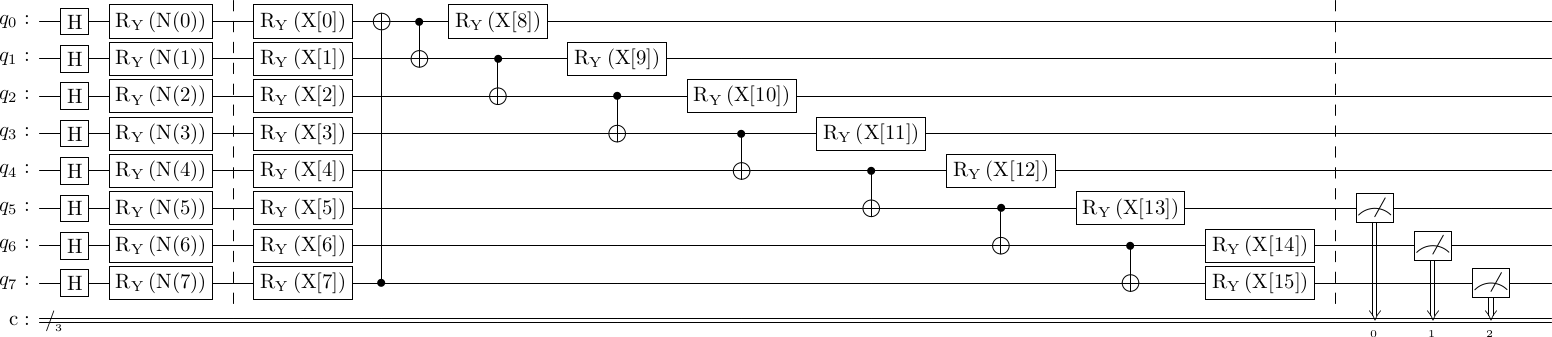

In [14]:
### Building partial QAE for its training without a swap test
sample_ae, _, _ = half_qae_encoder(5, 3, reps=1, ent='sca')
print('\nExample autoencoder circuit:\n')
display(sample_ae.decompose().draw("latex", style="iqp", scale=1))

**Figure: Half-QAE structure for training using only Encoder and measurements of qubit states**<br/>
The $\lvert 0 \rangle$ state of trash qubits is determined by the cost function: $cost = 1-P(\lvert 0 \rangle^n)$ (with n - number of qubits in trash space)

***

### Full-QAE ZZ/XY AE and (optionally) previously trained Decoder$^\dagger$:<br/>Noisy Input + Encoder + Latent Space + Decoder + Pure Input$^\dagger$
It creates a full QAE to train its encoder optionally using the previously trained decoder$^\dagger$ by converging the output to $\vert 0 \rangle^n$.<br/>
The encoder is to be trained with noisy input trough the latent space, then the decoder (no $^\dagger$), pure data$^\dagger$, to result in $\vert 0 \rangle^n$.<br/>
For training, all qubits of this Full-QAE will be measured.


Example autoencoder circuit
Note: Decoder is either an inverse of the encoder or an independent decoder block):

In/Out  parameters:
[Parameter(N(0)), Parameter(N(1)), Parameter(N(2)), Parameter(N(3)), Parameter(N(4)), Parameter(N(5)), Parameter(N(6)), Parameter(N(7)), Parameter(O(0)), Parameter(O(1)), Parameter(O(2)), Parameter(O(3)), Parameter(O(4)), Parameter(O(5)), Parameter(O(6)), Parameter(O(7))]

Encoder parameters:
ParameterView([ParameterVectorElement(X[0]), ParameterVectorElement(X[1]), ParameterVectorElement(X[2]), ParameterVectorElement(X[3]), ParameterVectorElement(X[4]), ParameterVectorElement(X[5]), ParameterVectorElement(X[6]), ParameterVectorElement(X[7]), ParameterVectorElement(X[8]), ParameterVectorElement(X[9]), ParameterVectorElement(X[10]), ParameterVectorElement(X[11]), ParameterVectorElement(X[12]), ParameterVectorElement(X[13]), ParameterVectorElement(X[14]), ParameterVectorElement(X[15]), ParameterVectorElement(X[16]), ParameterVectorElement(X[17]), Parameter

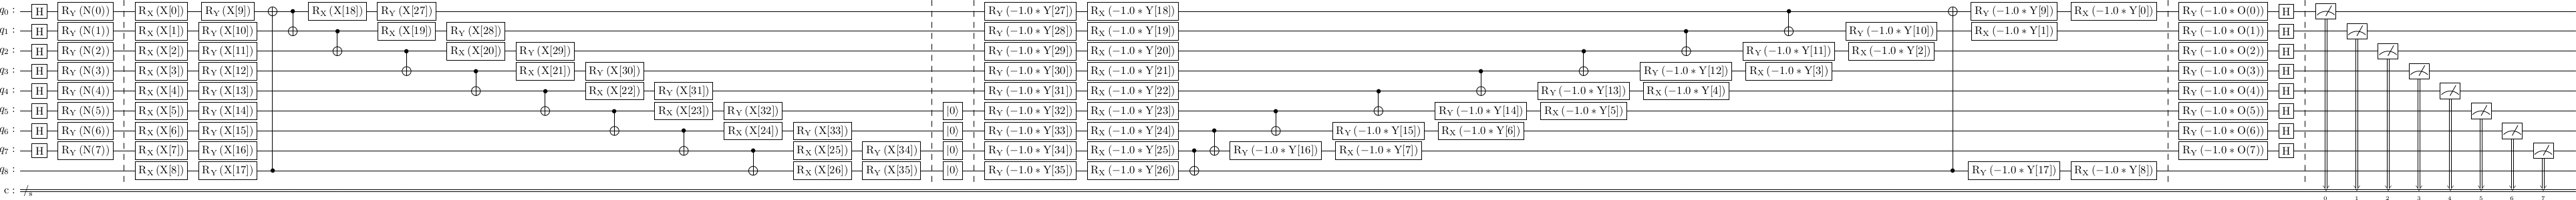

In [15]:
### Test a full encoder circuit for training
sample_tqae, in_out_params, enc_params, dec_params, all_weight_params = \
    train_qae_xyz_xdf(5, 3, reps=1, fm_reps=1, ent='sca', in_seq_label='N', in_seq_name='Noisy Input')
print('\nExample autoencoder circuit'+
      '\nNote: Decoder is either an inverse of the encoder or an independent decoder block):')

print(f'\nIn/Out  parameters:\n{in_out_params}')
print(f'\nEncoder parameters:\n{enc_params}')
print(f'\nDecoder parameters:\n{dec_params}')
print(f'\nWeight parameters:\n{all_weight_params}\n')
print(f'\nNumber of parameters: {sample_tqae.num_parameters}\n\n')

# display(sample_tqae.decompose().draw("latex", style="iqp", scale=0.8, cregbundle=False))
display(sample_tqae.decompose().draw("latex", style="iqp", scale=0.8, fold=-1)) # latex, mpl, 
print()

### Full-QAE: Input + Encoder + Decoder + Output + No Swap Test
*Note: Position of the output block may vary<br/>Note: Decoder could be an inverse of encoder or become an independent block*


Example autoencoder circuit
Note: Decoder is either an inverse of the encoder or an independent decoder block):

In/Out  parameters:
[Parameter(N(0)), Parameter(N(1)), Parameter(N(2)), Parameter(N(3)), Parameter(N(4)), Parameter(N(5)), Parameter(N(6)), Parameter(N(7)), Parameter(O(0)), Parameter(O(1)), Parameter(O(2)), Parameter(O(3)), Parameter(O(4)), Parameter(O(5)), Parameter(O(6)), Parameter(O(7))]

Encoder parameters:
ParameterView([ParameterVectorElement(X[0]), ParameterVectorElement(X[1]), ParameterVectorElement(X[2]), ParameterVectorElement(X[3]), ParameterVectorElement(X[4]), ParameterVectorElement(X[5]), ParameterVectorElement(X[6]), ParameterVectorElement(X[7]), ParameterVectorElement(X[8]), ParameterVectorElement(X[9]), ParameterVectorElement(X[10]), ParameterVectorElement(X[11]), ParameterVectorElement(X[12]), ParameterVectorElement(X[13]), ParameterVectorElement(X[14]), ParameterVectorElement(X[15])])

Decoder parameters:
ParameterView([ParameterVectorElement(Y[0]), Para

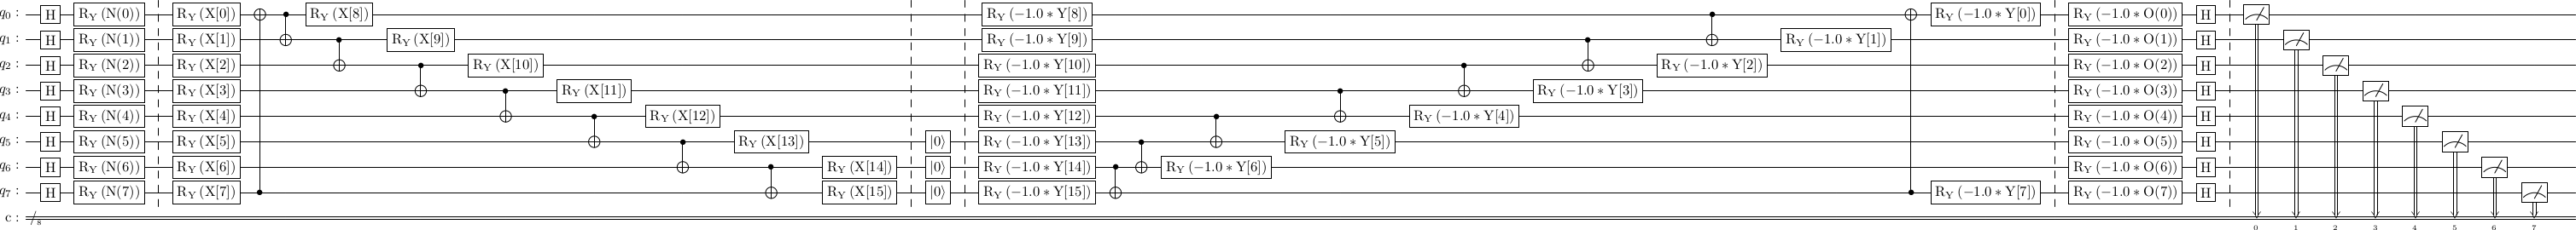

In [16]:
### Test a full encoder circuit for training
sample_tqae, in_out_params, enc_params, dec_params, all_weight_params = \
    train_qae(5, 3, reps=1, ent='sca', in_seq_label='N', in_seq_name='Noisy Input')
print('\nExample autoencoder circuit'+
      '\nNote: Decoder is either an inverse of the encoder or an independent decoder block):')

print(f'\nIn/Out  parameters:\n{in_out_params}')
print(f'\nEncoder parameters:\n{enc_params}')
print(f'\nDecoder parameters:\n{dec_params}')
print(f'\nWeight parameters:\n{all_weight_params}\n\n')

# display(sample_tqae.decompose().draw("latex", style="iqp", scale=0.8, cregbundle=False))
display(sample_tqae.decompose().draw("latex", style="iqp", scale=0.8, fold=-1)) # latex, mpl, 
print()

**Figure: Full-QAE structure for training (using Encoder+Decoder without a Swap Test)**<br/>
*The swap test is performed on all input/output qubits to determine the value of our cost function.<br/><br/>
Note: Position of the output block may vary<br/>Note: Decoder could be an inverse of encoder or become an independent block*

### Testing Circuit - The entire QAE

The full Autoencoder consists of both the Encoder and Decoder, which is simply an inverted Encoder. 
Both the Encoder and Decoder can be initialised using the same parameters obtained from the Encoder (plus swap test) training.
By applying the full QAE circuit to a test dataset, we can then determine the model accuracy.



QAE Input Parameters 8: ParameterView([Parameter(I(0)), Parameter(I(1)), Parameter(I(2)), Parameter(I(3)), Parameter(I(4)), Parameter(I(5)), Parameter(I(6)), Parameter(I(7))])

Encoder Weights 36: ParameterView([ParameterVectorElement(X[0]), ParameterVectorElement(X[1]), ParameterVectorElement(X[2]), ParameterVectorElement(X[3]), ParameterVectorElement(X[4]), ParameterVectorElement(X[5]), ParameterVectorElement(X[6]), ParameterVectorElement(X[7]), ParameterVectorElement(X[8]), ParameterVectorElement(X[9]), ParameterVectorElement(X[10]), ParameterVectorElement(X[11]), ParameterVectorElement(X[12]), ParameterVectorElement(X[13]), ParameterVectorElement(X[14]), ParameterVectorElement(X[15]), ParameterVectorElement(X[16]), ParameterVectorElement(X[17]), ParameterVectorElement(X[18]), ParameterVectorElement(X[19]), ParameterVectorElement(X[20]), ParameterVectorElement(X[21]), ParameterVectorElement(X[22]), ParameterVectorElement(X[23]), ParameterVectorElement(X[24]), ParameterVectorElemen

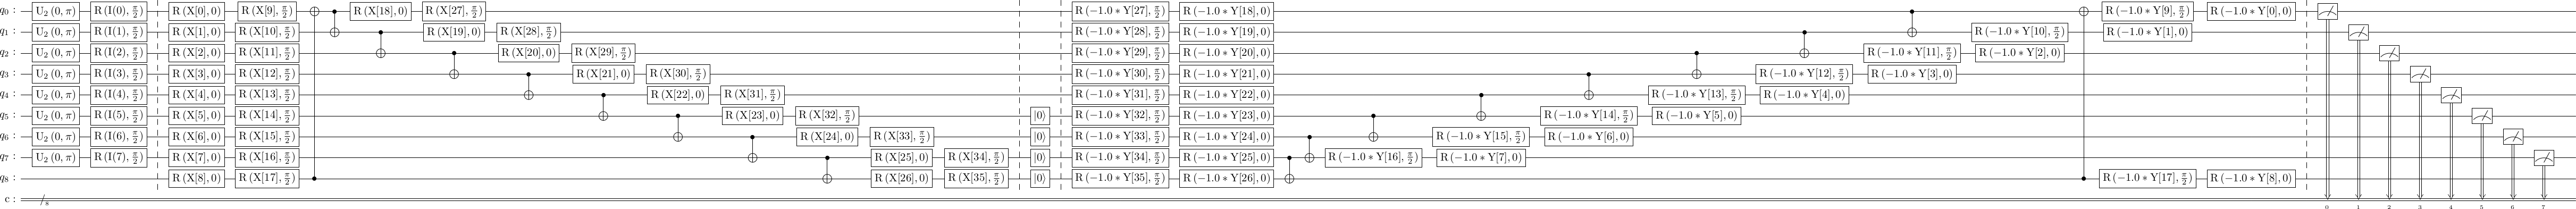

In [17]:
### Full QAE for testing the previously trained model
sample_qae_qc, in_params, enc_params, dec_params, all_weights_params = qae_xyz_xdf(5, 3, reps=1, ent='sca')

### Show a sample test circuit - the sequence feature map and the ansatz will beused further
print()
print(f'\nQAE Input Parameters {len(in_params)}: {in_params}')
print(f'\nEncoder Weights {len(enc_params)}: {enc_params}')
print(f'\nDecoder Weights {len(dec_params)}: {dec_params}')
print(f'\nTotal Weights {len(all_weights_params)}: {all_weights_params}')
print('\n')

# display(sample_qae_qc.decompose().decompose().draw("latex", style="iqp", scale=1))
display(sample_qae_qc.decompose().decompose().draw("latex", style="iqp", scale=1))


**Figure: Full QAE capable of mapping input sequence to its output (after Encoder/Decoder training)**

*Note: Decoder could be an inverse of encoder or become an independent block*

## Software used

In [18]:
!pip list | grep -e qiskit

qiskit                        0.45.2
qiskit-aer-gpu                0.13.2
qiskit-algorithms             0.2.2
qiskit-dynamics               0.4.3
qiskit-finance                0.4.0
qiskit-ibm-provider           0.6.3
qiskit-ibm-runtime            0.11.3
qiskit-ibmq-provider          0.20.2
qiskit-machine-learning       0.7.1
qiskit-nature                 0.7.1
qiskit-optimization           0.6.0
qiskit-qasm3-import           0.4.1
qiskit-sphinx-theme           1.12.1
qiskit-terra                  0.45.2
